In [3]:
from google.colab import files
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import json

# Download dataset from kaggle
You need to have your kaggle API token.  
*   go to your kaggle account
*   scroll down and click "create new API token" button
*   upload your own kaggle.json to your colab

In [4]:
# Upload your kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samanthak","key":"fdd8007802a172c276f2336f2ca6a021"}'}

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d cdawn1/messy-vs-clean-room
! unzip messy-vs-clean-room.zip

 74% 50.0M/67.1M [00:00<00:00, 105MB/s]
100% 67.1M/67.1M [00:00<00:00, 136MB/s]
Archive:  messy-vs-clean-room.zip
  inflating: images/images/test/0.png  
  inflating: images/images/test/1.png  
  inflating: images/images/test/2.png  
  inflating: images/images/test/3.png  
  inflating: images/images/test/4.png  
  inflating: images/images/test/5.png  
  inflating: images/images/test/6.png  
  inflating: images/images/test/7.png  
  inflating: images/images/test/8.png  
  inflating: images/images/test/9.png  
  inflating: images/images/train/clean/0.png  
  inflating: images/images/train/clean/1.png  
  inflating: images/images/train/clean/10.png  
  inflating: images/images/train/clean/11.png  
  inflating: images/images/train/clean/12.png  
  inflating: images/images/train/clean/13.png  
  inflating: images/images/train/clean/14.png  
  inflating: images/images/train/clean/15.png  
  inflating: images/images/train/clean/16.png  
  inflating: images/images/train/clean/17.png  
  inflat

# Explore the data

In [ ]:
# get image paths from folders
clean_training_images = [os.path.abspath('images/train/clean/'+x) for x in os.listdir('images/train/clean')]
messy_training_images = [os.path.abspath('images/train/messy/'+x) for x in os.listdir('images/train/messy')]
clean_val_images = [os.path.abspath('images/val/clean/'+x) for x in os.listdir('images/val/clean')]
messy_val_images = [os.path.abspath('images/val/messy/'+x) for x in os.listdir('images/val/messy')]

clean_images = clean_training_images + clean_val_images
messy_images = messy_training_images + messy_val_images

In [ ]:
# show clean images
plt.figure(figsize=(15,15))
for i,path in enumerate(random.sample(clean_images, 9)):
  plt.subplot(3,3,i+1)
  img = plt.imread(path)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'label : {path.split("/")[-2]}')
plt.show()

In [ ]:
# show messy images
plt.figure(figsize=(15,15))
for i,path in enumerate(random.sample(messy_images, 9)):
  plt.subplot(3,3,i+1)
  img = plt.imread(path)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'label : {path.split("/")[-2]}')
plt.show()

# Data preprocessing

In [ ]:
# create data generator
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 32 
training_set = train_datagen.flow_from_directory('images/train',
                                                 target_size = (128,128),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

val_set = val_datagen.flow_from_directory('images/val',
                                            target_size=(128,128),
                                            batch_size = 10,
                                            class_mode = 'binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


# Baseline Model

In [ ]:
# create function for plotting

def plot_history(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    plt.title('accuracy')
    
    plt.show()

In [ ]:
# initialize CNN
clf = Sequential()
# first set of conv+pooling
clf.add(Conv2D(32,(3,3), input_shape=(128,128,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
# second set
clf.add(Conv2D(32,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
# flattening
clf.add(Flatten())
# full connection
clf.add(Dense(units=128, activation='relu'))
clf.add(Dropout(0.3))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.4))
clf.add(Dense(units=1, activation='sigmoid'))

# compiling the CNN
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# training the CNN
history = clf.fit_generator (training_set,
                  steps_per_epoch = len(training_set),
                  epochs = 100,
                  validation_data = val_set,
                  validation_steps = len(val_set),
                  callbacks = [es])

# plot history
plot_history(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
6/6 [==============================] - 5s 645ms/step - loss: 0.9350 - accuracy: 0.5833 - val_loss: 0.6825 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 4s 615ms/step - loss: 0.6682 - accuracy: 0.5833 - val_loss: 0.6603 - val_accuracy: 0.5000
Epoch 3/100
6/6 [==============================] - 4s 609ms/step - loss: 0.6534 - accuracy: 0.5938 - val_loss: 0.6436 - val_accuracy: 0.7500
Epoch 4/100
6/6 [==============================] - 4s 609ms/step - loss: 0.5916 - accuracy: 0.7656 - val_loss: 0.5853 - val_accuracy: 0.6500
Epoch 5/100
6/6 [==============================] - 4s 607ms/step - loss: 0.6131 - accuracy: 0.6927 - val_loss: 0.6220 - val_accuracy: 0.6000
Epoch 6/100
6/6 [==============================] - 4s 609ms/step - loss: 0.5030 - accuracy: 0.7656 - val_loss: 0.5091 - val_accuracy: 0.7500
Epoch 7/100
6/6 [==============================] - 4s 607ms/step - loss: 0.4406 - accuracy: 0.8177 - val_loss: 0.4252 - val_accuracy: 0.8000
Epoch 8/100
6

# Improve model

## Model 1 : Add Dropout layers between Conv2D blocks

In [ ]:
# initialize CNN
clf = Sequential()
# first set of conv+pooling
clf.add(Conv2D(32,(3,3), input_shape=(128,128,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.2))
# second set
clf.add(Conv2D(32,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.2))
# flattening
clf.add(Flatten())
# full connection
clf.add(Dense(units=128, activation='relu'))
clf.add(Dropout(0.3))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.4))
clf.add(Dense(units=1, activation='sigmoid'))

# compiling the CNN
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# training the CNN
history = clf.fit_generator (training_set,
                  steps_per_epoch = len(training_set),
                  epochs = 100,
                  validation_data = val_set,
                  validation_steps = len(val_set),
                  callbacks = [es])

# plot history
plot_history(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
6/6 [==============================] - 5s 706ms/step - loss: 1.0204 - accuracy: 0.5365 - val_loss: 0.7022 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 4s 664ms/step - loss: 0.8041 - accuracy: 0.4635 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 3/100
6/6 [==============================] - 4s 665ms/step - loss: 0.6821 - accuracy: 0.5365 - val_loss: 0.6761 - val_accuracy: 0.5000
Epoch 4/100
6/6 [==============================] - 4s 664ms/step - loss: 0.6610 - accuracy: 0.5417 - val_loss: 0.6751 - val_accuracy: 0.6500
Epoch 5/100
6/6 [==============================] - 4s 663ms/step - loss: 0.5988 - accuracy: 0.6927 - val_loss: 0.6215 - val_accuracy: 0.6500
Epoch 6/100
6/6 [==============================] - 4s 667ms/step - loss: 0.5327 - accuracy: 0.7604 - val_loss: 0.5190 - val_accuracy: 0.7500
Epoch 7/100
6/6 [==============================] - 4s 660ms/step - loss: 0.5559 - accuracy: 0.7188 - val_loss: 0.5176 - val_accuracy: 0.7500
Epoch 8/100
6

## Model 2 : more filters in second Conv2d and set padding='same'

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
6/6 [==============================] - 6s 923ms/step - loss: 1.4370 - accuracy: 0.5208 - val_loss: 0.7037 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 5s 887ms/step - loss: 0.7617 - accuracy: 0.5260 - val_loss: 0.6912 - val_accuracy: 0.7000
Epoch 3/100
6/6 [==============================] - 5s 883ms/step - loss: 0.6779 - accuracy: 0.5312 - val_loss: 0.6750 - val_accuracy: 0.5500
Epoch 4/100
6/6 [==============================] - 5s 882ms/step - loss: 0.6535 - accuracy: 0.5781 - val_loss: 0.6389 - val_accuracy: 0.8000
Epoch 5/100
6/6 [==============================] - 5s 881ms/step - loss: 0.5813 - accuracy: 0.7448 - val_loss: 0.5405 - val_accuracy: 0.8000
Epoch 6/100
6/6 [==============================] - 5s 875ms/step - loss: 0.5301 - accuracy: 0.7500 - val_loss: 0.5827 - val_accuracy: 0.6500
Epoch 7/100
6/6 [==============================] - 5s 880ms/step - loss: 0.5153 - accuracy: 0.7604 - val_loss: 0.4655 - val_accuracy: 0.8000
Epoch 8/100
6

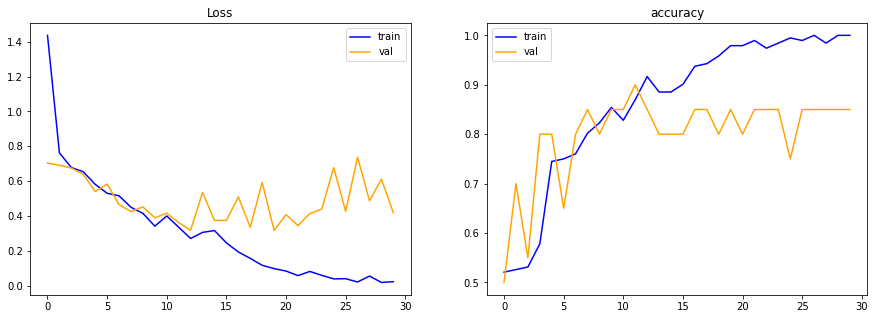

In [ ]:
# initialize CNN
clf = Sequential()
# first set of conv+pooling
clf.add(Conv2D(32,(3,3), padding='same', input_shape=(128,128,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.2))
# second set
clf.add(Conv2D(64,(3,3), padding='same', activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.2))
# flattening
clf.add(Flatten())
# full connection
clf.add(Dense(units=128, activation='relu'))
clf.add(Dropout(0.3))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.4))
clf.add(Dense(units=1, activation='sigmoid'))

# compiling the CNN
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# training the CNN
history = clf.fit_generator (training_set,
                  steps_per_epoch = len(training_set),
                  epochs = 100,
                  validation_data = val_set,
                  validation_steps = len(val_set),
                  callbacks = [es])

# plot history
plot_history(history)

## Model 3 : more Conv2D

In [ ]:
# initialize CNN
clf = Sequential()
# first set of conv+pooling
clf.add(Conv2D(32,(3,3), padding='same', input_shape=(128,128,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.2))
# second set
clf.add(Conv2D(64,(3,3), padding='same', activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.2))
# third set
clf.add(Conv2D(128,(3,3), padding='same', activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.2))
# flattening
clf.add(Flatten())
# full connection
clf.add(Dense(units=128, activation='relu'))
clf.add(Dropout(0.3))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.4))
clf.add(Dense(units=1, activation='sigmoid'))

# compiling the CNN
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# training the CNN
history = clf.fit_generator (training_set,
                  steps_per_epoch = len(training_set),
                  epochs = 100,
                  validation_data = val_set,
                  validation_steps = len(val_set),
                  callbacks = [es])

# plot history
plot_history(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
6/6 [==============================] - 8s 1s/step - loss: 0.9282 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 0.6970 - accuracy: 0.4427 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.6920 - accuracy: 0.4948 - val_loss: 0.6859 - val_accuracy: 0.5000
Epoch 4/100
6/6 [==============================] - 7s 1s/step - loss: 0.6835 - accuracy: 0.5208 - val_loss: 0.6774 - val_accuracy: 0.7500
Epoch 5/100
6/6 [==============================] - 7s 1s/step - loss: 0.6797 - accuracy: 0.5156 - val_loss: 0.6804 - val_accuracy: 0.6000
Epoch 6/100
6/6 [==============================] - 7s 1s/step - loss: 0.6890 - accuracy: 0.5417 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 7/100
6/6 [==============================] - 7s 1s/step - loss: 0.6960 - accuracy: 0.4688 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 8/100
6/6 [=================

## Model 4 : more Conv2D layer and increasing dropout rate

In [ ]:
# initialize CNN
clf = Sequential()
# first set of conv+pooling
clf.add(Conv2D(32,(3,3), padding='same', input_shape=(128,128,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.2))
# second set
clf.add(Conv2D(64,(3,3), padding='same', activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.3))
# third set
clf.add(Conv2D(128,(3,3), padding='same', activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.4))
# third set
clf.add(Conv2D(256,(3,3), padding='same', activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.5))
# flattening
clf.add(Flatten())
# full connection
clf.add(Dense(units=128, activation='relu'))
clf.add(Dropout(0.3))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.4))
clf.add(Dense(units=1, activation='sigmoid'))

# compiling the CNN
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# training the CNN
history = clf.fit_generator (training_set,
                  steps_per_epoch = len(training_set),
                  epochs = 100,
                  validation_data = val_set,
                  validation_steps = len(val_set),
                  callbacks = [es])

# plot history
plot_history(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
6/6 [==============================] - 9s 1s/step - loss: 0.8435 - accuracy: 0.5469 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.6967 - accuracy: 0.5469 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/100
6/6 [==============================] - 8s 1s/step - loss: 0.6891 - accuracy: 0.5417 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 4/100
6/6 [==============================] - 8s 1s/step - loss: 0.6901 - accuracy: 0.5312 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 5/100
6/6 [==============================] - 8s 1s/step - loss: 0.6976 - accuracy: 0.5052 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/100
6/6 [==============================] - 8s 1s/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/100
6/6 [==============================] - 8s 1s/step - loss: 0.6836 - accuracy: 0.5885 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 8/100
6/6 [=================

## Model 5 : use pretrained VGG16 as an integrated feature extractor

In [ ]:
# load the pretrained model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add new classifier part
flat1 = Flatten()(model.output)
dense1 = Dense(1024, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(dense1)
# define model
model = Model(inputs=model.inputs, outputs=output)  
# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']s)

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# training the CNN
history = model.fit_generator (training_set,
                  steps_per_epoch = len(training_set),
                  epochs = 100,
                  validation_data = val_set,
                  validation_steps = len(val_set),
                  callbacks = [es])

# plot history
plot_history(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
6/6 [==============================] - 32s 5s/step - loss: 2.7981 - accuracy: 0.4844 - val_loss: 0.2088 - val_accuracy: 0.8500
Epoch 2/100
6/6 [==============================] - 31s 5s/step - loss: 0.1946 - accuracy: 0.9167 - val_loss: 0.1010 - val_accuracy: 0.9500
Epoch 3/100
6/6 [==============================] - 31s 5s/step - loss: 0.1256 - accuracy: 0.9688 - val_loss: 0.2235 - val_accuracy: 0.8500
Epoch 4/100
6/6 [==============================] - 31s 5s/step - loss: 0.0871 - accuracy: 0.9635 - val_loss: 0.0944 - val_accuracy: 0.9500
Epoch 5/100
6/6 [==============================] - 31s 5s/step - loss: 0.0544 - accuracy: 0.9896 - val_loss: 0.0767 - val_accuracy: 1.0000
Epoch 6/100
6/6 [==============================] - 31s 5s/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.1341 - val_accuracy: 0.9500
Epoch 7/100
6/6 [==============================] - 31s 5s/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0832 - val_accuracy: 1.0000
Epoch 8/100
6/6 [==========

## Model 6 : use pretrained mobilenet as an integrated feature extractor

17620992/17605208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
6/6 [==============================] - 7s 563ms/step - loss: 1.4264 - accuracy: 0.5521 - val_loss: 1.6626 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 2s 364ms/step - loss: 0.9291 - accuracy: 0.5729 - val_loss: 1.0386 - val_accuracy: 0.5000
Epoch 3/100
6/6 [==============================] - 2s 364ms/step - loss: 0.7955 - accuracy: 0.5417 - val_loss: 0.8736 - val_accuracy: 0.5000
Epoch 4/100
6/6 [==============================] - 2s 365ms/step - loss: 0.7701 - accuracy: 0.5208 - val_loss: 0.6448 - val_accuracy: 0.6500
Epoch 5/100
6/6 [==============================] - 2s 365ms/step - loss: 0.6032 - accuracy: 0.6250 - val_loss: 0.6488 - val_accuracy: 0.5500
Epoch 6/100
6/6 [==============================] - 2s 365ms/step - loss: 0.6181 - accuracy: 0.6354 - val_loss: 0.4971 - val_accuracy: 0.7500
Epoch 7/100
6/6 [==============================] - 2s 362ms/step - loss: 0.5903 - accuracy: 0.7031 - val_loss: 0.4852 - val_accuracy: 0.7000
Epoch 8/100
6

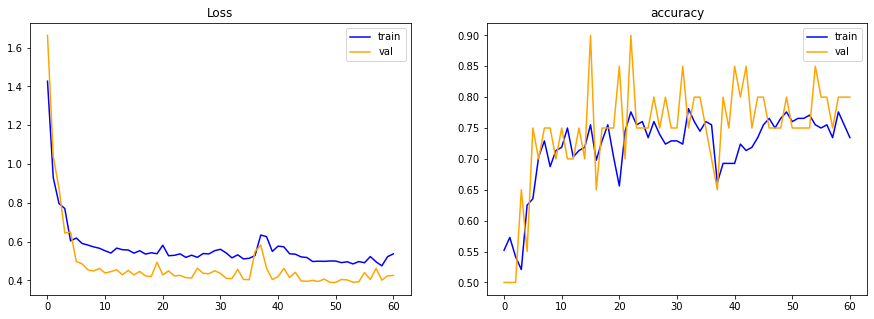

In [ ]:
# load the pretrained model
model = MobileNetV3Large(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add new classifier part
flat1 = Flatten()(model.output)
dense1 = Dense(1024, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(dense1)
# define model
model = Model(inputs=model.inputs, outputs=output)  
# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# training the CNN
history = model.fit_generator (training_set,
                  steps_per_epoch = len(training_set),
                  epochs = 100,
                  validation_data = val_set,
                  validation_steps = len(val_set),
                  callbacks = [es])

# plot history
plot_history(history)

## Model 7 : use pretrained ResNet50 as an integrated feature extractor

In [ ]:
# load the pretrained model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add new classifier part
flat1 = Flatten()(model.output)
dense1 = Dense(1024, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(dense1)
# define model
model = Model(inputs=model.inputs, outputs=output)  
# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# training the CNN
history = model.fit_generator (training_set,
                  steps_per_epoch = len(training_set),
                  epochs = 100,
                  validation_data = val_set,
                  validation_steps = len(val_set),
                  callbacks = [es])

# plot history
plot_history(history)

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
6/6 [==============================] - 16s 2s/step - loss: 1.8516 - accuracy: 0.5365 - val_loss: 1.7248 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 12s 2s/step - loss: 1.0131 - accuracy: 0.5729 - val_loss: 0.5642 - val_accuracy: 0.6500
Epoch 3/100
6/6 [==============================] - 12s 2s/step - loss: 0.5692 - accuracy: 0.6979 - val_loss: 0.5017 - val_accuracy: 0.7000
Epoch 4/100
6/6 [==============================] - 12s 2s/step - loss: 0.4761 - accuracy: 0.7656 - val_loss: 0.4579 - val_accuracy: 0.8500
Epoch 5/100
6/6 [==============================] - 12s 2s/step - loss: 0.4599 - accuracy: 0.7969 - val_loss: 0.4338 - val_accuracy: 0.8500
Epoch 6/100
6/6 [==============================] - 12s 2s/step - loss: 0.4194 - accuracy: 0.7969 - val_loss: 0.4485 - val_accuracy: 0.7000
Epoch 7/100
6/6 [==============================] - 12s 2s/step - loss: 0.3899 - accuracy: 0.8438 - val_loss: 0.4251 - val_accuracy: 0.8000
Epoch 8/100
6/6 [==========

# Finalize the model : pretrained VGG16 as an integrated feature extractor in the model


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
6/6 [==============================] - 33s 6s/step - loss: 2.4139 - accuracy: 0.5729 - val_loss: 2.3507 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 2.35073, saving model to messy_or_clean_clf.h5
Epoch 2/100
6/6 [==============================] - 32s 5s/step - loss: 0.9610 - accuracy: 0.7188 - val_loss: 0.8556 - val_accuracy: 0.7000

Epoch 00002: val_loss improved from 2.35073 to 0.85558, saving model to messy_or_clean_clf.h5
Epoch 3/100
6/6 [==============================] - 32s 5s/step - loss: 0.4047 - accuracy: 0.8594 - val_loss: 0.2061 - val_accuracy: 0.9500

Epoch 00003: val_loss improved from 0.85558 to 0.20607, saving model to messy_or_clean_clf.h5
Epoch 4/100
6/6 [==============================] - 32s 5s/step - loss: 0.2579 - accuracy: 0.9010 - val_loss: 0.1087 - val_accuracy: 0.9500

Epoch 00004: val_loss improved from 0.20607 to 0.10873, saving model to messy_or_clean_clf.h5
Epoch 5/100
6/6 [==============================] - 32s 5s/step - los

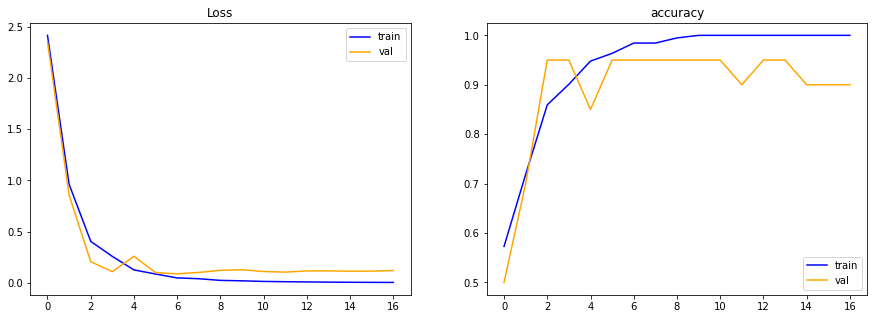

In [ ]:
# load the pretrained model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False
# add new classifier part
flat1 = Flatten()(model.output)
dense1 = Dense(1024, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(dense1)
# define model
model = Model(inputs=model.inputs, outputs=output)  
# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# create model checkpoint to save the model
mc = ModelCheckpoint('messy_or_clean_clf.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# training the CNN
history = model.fit_generator (training_set,
                  steps_per_epoch = len(training_set),
                  epochs = 100,
                  validation_data = val_set,
                  validation_steps = len(val_set),
                  callbacks = [es, mc])

# plot history
plot_history(history)

# Save the model (option 1)
This method saves the model as a single file.  
Another method is to save the model and weights separately (see last section).

In [ ]:
# save model file to local machine
from google.colab import files
files.download('messy_or_clean_clf.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prediction

In [ ]:
# check the class index before show the result
training_set.class_indices

{'clean': 0, 'messy': 1}

In [ ]:
class_map = {num:cls for cls, num in training_set.class_indices.items()}
class_map

{0: 'clean', 1: 'messy'}

## Load the saved model

In [ ]:
model = load_model('messy_or_clean_clf.h5')

## Make prediction on test images (batch)

In [ ]:
# prepare test image
test_images = [os.path.abspath('images/test/'+x) for x in os.listdir('images/test')]
X_test = []
for path in test_images :
  img = image.load_img(path, target_size=(128,128))
  img_array = image.img_to_array(img)
  X_test.append(img_array)
X_test = np.array(X_test)
print(X_test.shape)

(10, 128, 128, 3)


In [ ]:
# make prediction
y_pred = model.predict(X_test)
y_pred = np.squeeze(y_pred)
y_pred = np.round(y_pred)

In [ ]:
y_pred

array([1., 1., 0., 1., 0., 1., 1., 0., 1., 0.], dtype=float32)

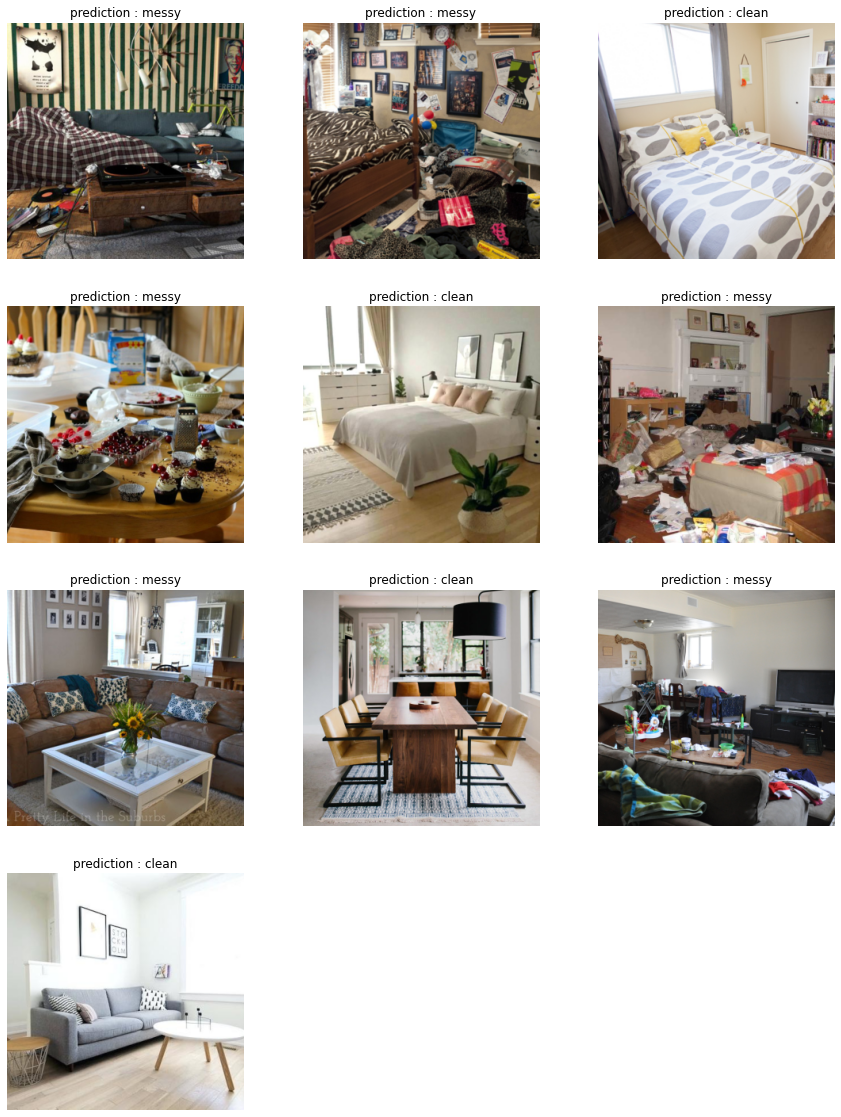

In [ ]:
# printing the prediction result
if len(test_images) % 3 != 0 :
  num_rows = len(test_images) // 3 +1
else :
  num_rows = len(test_images) // 3

plt.figure(figsize=(15, num_rows*5))
for i, path in enumerate(test_images):
  img = plt.imread(path)
  plt.subplot(num_rows, 3, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'prediction : {class_map[y_pred[i]]}')
plt.show()

# (Optional) save model and weight separately

In [6]:
model = load_model('messy_or_clean_clf.h5')

In [7]:
# save model
model_json = model.to_json()
with open("messy_or_clean_model.json", "w") as json_file:
    json_file.write(model_json)
# save weights to HDFS
model.save_weights("messy_or_clean_weights.h5")

In [10]:
# load
import tensorflow
with open('messy_or_clean_model.json','r') as json_file:
    model_json = json_file.read()
model = tensorflow.keras.models.model_from_json(model_json)
model.load_weights('messy_or_clean_weights.h5')

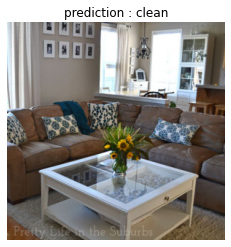

In [17]:
# make prediction
img = image.load_img('/content/images/test/0.png', target_size=(128,128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, 0)

prediction = model.predict(img_array)
prediction = np.round(prediction)

plt.imshow(plt.imread('/content/images/test/0.png'))
plt.axis('off')
plt.title(f'prediction : {class_map[prediction[0][0]]}')
plt.show()

## save to local machine

In [18]:
# save model file to local machine
from google.colab import files
files.download('messy_or_clean_model.json')
files.download('messy_or_clean_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>